In [1]:
import pandas as pd
from pathlib import Path

out_dir = Path("../results")
out_dir.mkdir(parents=True, exist_ok=True)

# Read the sweep results CSV
# add level of difficulty
data = pd.read_csv('../exp4_bestof_sweep/sweep_results.csv')
# Change the values in the 'difficulty' column: if 'easy-med', set as 'medium'
data['difficulty'] = data['difficulty'].replace({'easy-med': 'medium', 'easy-medium': 'medium'})
data.head(5)

,sweep_id,repetition,test_case,prompt,difficulty,two_stage_cot,best_of_n,temperature,temperature_max,csv_score,csv_columns_iou,csv_rows_iou,csv_cells_iou,text_score,viz_spec_score,best_score,duration_ms,total_emissions_kg,test_dir
0,1,1,1,What is the total sales in october 2022 ?,easy,False,1,0,0.15,1.0,0.0,0.0,1.0,0.715778,0,1.715780,41723,NaN,./output/exp4_bestof_sweep/rep1_tsfalse_bon1_t...
1,1,1,2,How many units we sold in september 2022 ?,easy,False,1,0,0.15,0.0,0.0,0.0,0.0,0.363511,0,0.363511,20820,3.177450e-07,./output/exp4_bestof_sweep/rep1_tsfalse_bon1_t...
2,1,1,3,Find product categories that decreased sales d...,medium,False,1,0,0.15,0.0,0.0,0.0,0.0,0.000011,0,0.000011,24854,2.860850e-07,./output/exp4_bestof_sweep/rep1_tsfalse_bon1_t...
3,1,1,4,How much was the variational change between in...,medium,False,1,0,0.15,0.0,0.0,0.0,0.0,0.263344,0,0.263344,22950,2.831320e-07,./output/exp4_bestof_sweep/rep1_tsfalse_bon1_t...
4,1,1,5,Which store has the most sales in october 2022 ?,easy,False,1,0,0.15,0.5,0.5,0.5,0.5,0.706988,0,1.206990,21562,3.092870e-07,./output/exp4_bestof_sweep/rep1_tsfalse_bon1_t...


In [2]:
data.columns

Index(['sweep_id', 'repetition', 'test_case', 'prompt', 'difficulty',
       'two_stage_cot', 'best_of_n', 'temperature', 'temperature_max',
       'csv_score', 'csv_columns_iou', 'csv_rows_iou', 'csv_cells_iou',
       'text_score', 'viz_spec_score', 'best_score', 'duration_ms',
       'total_emissions_kg', 'test_dir'],
      dtype='object')

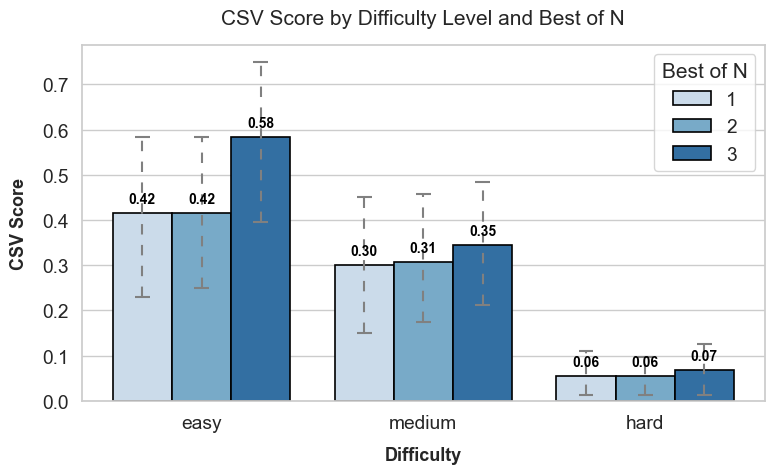

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pretty_bar(
    x, y, hue, data,
    title,
    y_name, x_name,
    out_path=None,
    col=None,
    figsize=(8, 5),
    legend_title=None,
    errorbar=("ci", 95),
    err_kws=None,
    palette="Blues",
    x_tick_fontsize=None  # New option to reduce the size of x-axis labels
):
    """
    Create a prettified seaborn bar plot with value labels and fancy error bar caps.

    Parameters:
    - x, y, hue: Columns for plot axes
    - data: DataFrame to plot
    - title: Plot title
    - y_name, x_name: Labels for axes
    - out_path: Path to save figure (optional)
    - col: Column for grid facet (not currently supported here)
    - figsize: Figure size (tuple)
    - legend_title: Title for legend (str, optional)
    - errorbar: Errorbar specification (tuple or str)
    - err_kws: Dict for errorbar style
    - palette: Seaborn palette (default is "Blues" for blue color scale)
    - x_tick_fontsize: Font size for x axis tick labels (optional)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Theme
    sns.set_theme(style="whitegrid", font_scale=1.25)

    # Robust palette handling: accepts "Blues"/"blues" and other seaborn/matplotlib names.
    n_colors = 1
    if hue is not None and hasattr(data, "columns") and hue in data.columns:
        try:
            n_colors = int(data[hue].nunique())
        except Exception:
            n_colors = 1

    if isinstance(palette, str):
        pal_name = palette
        try:
            pal = sns.color_palette(pal_name, n_colors=n_colors)
        except Exception:
            try:
                pal = sns.color_palette(pal_name.capitalize(), n_colors=n_colors)
            except Exception:
                pal = sns.color_palette("Blues", n_colors=n_colors)
    else:
        pal = palette

    plt.figure(figsize=figsize)
    ax = sns.barplot(
        x=x,
        y=y,
        hue=hue,
        data=data,
        palette=pal,
        edgecolor='black',
        linewidth=1.2,
        alpha=1,
        errorbar=errorbar,
        err_kws=err_kws if err_kws else {"linestyle": (0, (5, 5)), "linewidth": 1.5, "color": "grey"}
    )

    # Add horizontal lines for error bars manually
    for container in ax.containers:
        for bar in container:
            x_bar = bar.get_x() + bar.get_width() / 2.0
            height = bar.get_height()
            for errline in ax.lines:
                xdata, ydata = errline.get_xdata(), errline.get_ydata()
                if (
                    len(xdata) == 2
                    and abs(x_bar - xdata[0]) < bar.get_width() / 2 + 1e-8
                ):
                    cap_width = bar.get_width() * 0.25
                    ax.hlines(y=ydata[1], xmin=x_bar - cap_width/2, xmax=x_bar + cap_width/2, color="grey", linewidth=1.5)
                    ax.hlines(y=ydata[0], xmin=x_bar - cap_width/2, xmax=x_bar + cap_width/2, color="grey", linewidth=1.5)

    n_hue = len(ax.get_legend_handles_labels()[1])  # Number of hue levels
    labeled_coords = dict()  # (rounded x position, hue) -> top y value

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        group_idx = i // n_hue
        hue_idx = i % n_hue
        x_coord = round(p.get_x() + p.get_width() / 2., 5)
        if not pd.isna(height):
            label_key = (x_coord, hue_idx)
            if label_key not in labeled_coords or height > labeled_coords[label_key]:
                labeled_coords[label_key] = height
                if height > 0 or all(not (k[0] == x_coord and v > 0) for k, v in labeled_coords.items()):
                    ax.annotate(
                        f"{height:.2f}",
                        (x_coord, height),
                        ha='center', va='bottom',
                        fontsize=10, fontweight='bold',
                        color='black', xytext=(0, 5), textcoords='offset points'
                    )

    legend_title = legend_title if legend_title is not None else hue if hue else ""
    if legend_title and ax.legend_:
        ax.legend(title=legend_title, loc="upper right", frameon=True)
    elif ax.legend_:
        ax.legend(loc="upper right", frameon=True)
    ax.set_xlabel(x_name, fontsize=13, fontweight='bold', labelpad=10)
    ax.set_ylabel(y_name, fontsize=13, fontweight='bold', labelpad=10)
    ax.set_title(title, fontsize=15, pad=15)

    # Option to change x-axis (category) tick label font size
    if x_tick_fontsize is not None:
        for tick in ax.get_xticklabels():
            tick.set_fontsize(x_tick_fontsize)

    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# Usage example using a blue palette:
plot_pretty_bar(
    x='difficulty',
    y='csv_score',
    hue='best_of_n',
    data=data,
    title="CSV Score by Difficulty Level and Best of N",
    y_name="CSV Score",
    x_name="Difficulty",
    out_path=out_dir / "difficulty_vs_csv_score_best_of_n.png",
    legend_title="Best of N",
    palette="Blues"
)

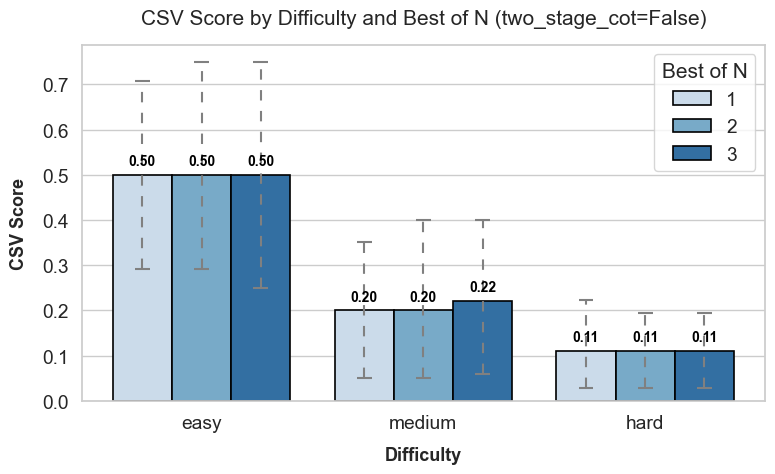

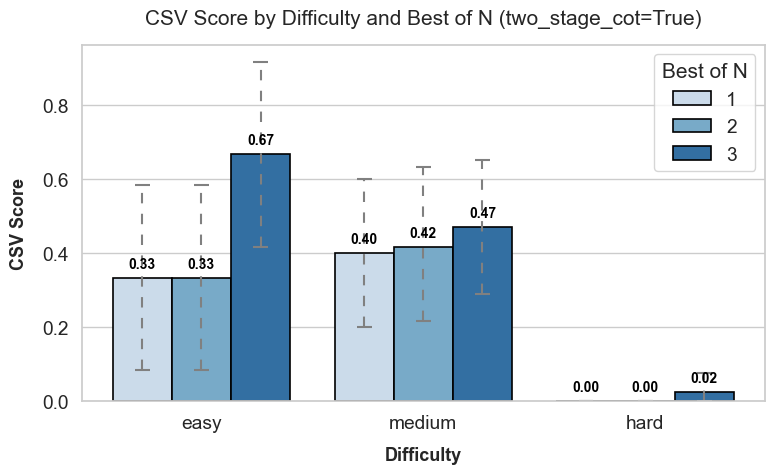

In [5]:
# Use plot_pretty_bar for the grouped bar plot with subplotting by 'two_stage_cot'
for two_stage_val, group in data.groupby('two_stage_cot'):
    plot_pretty_bar(
        x='difficulty',
        y='csv_score',
        hue='best_of_n',
        data=group,
        title=f"CSV Score by Difficulty and Best of N (two_stage_cot={two_stage_val})",
        y_name="CSV Score",
        x_name="Difficulty",
        out_path=out_dir / f"difficulty_vs_csv_score_best_of_n_two_stage_cot_{two_stage_val}.png",
        legend_title="Best of N"
    )

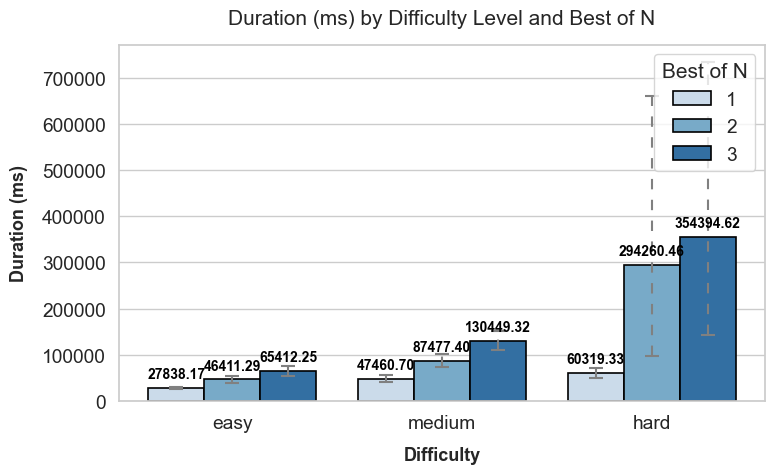

In [6]:
# Plot by level of difficulty, grouped by best_n using pretty bar plot
plot_pretty_bar(
    x='difficulty',
    y='duration_ms',
    hue='best_of_n',
    data=data,
    title="Duration (ms) by Difficulty Level and Best of N",
    y_name="Duration (ms)",
    x_name="Difficulty",
    out_path=out_dir / "difficulty_vs_duration_ms_best_of_n.png",
    legend_title="Best of N"
)

In [76]:
carbon = pd.read_csv('../exp5_bestof_sweep/stage_metrics_long.csv')
carbon.head(5)

,experiment,test_dir,test_case,rep,two_stage_cot,best_of_n,t0,tmax,prompt,stage,duration_ms,emissions_kg_est,stage_metrics_path
0,rep1_tsfalse_bon1_t0_tmax0p15,test_1,1,1,False,1,0.0,0.15,What is the total sales in october 2022 ?,analyzing_data,978,0.000008,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
1,rep1_tsfalse_bon1_t0_tmax0p15,test_1,1,1,False,1,0.0,0.15,What is the total sales in october 2022 ?,lookup_sales_data,2523,0.000021,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
2,rep1_tsfalse_bon1_t0_tmax0p15,test_2,2,1,False,1,0.0,0.15,How many units we sold in september 2022 ?,analyzing_data,714,0.000004,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
3,rep1_tsfalse_bon1_t0_tmax0p15,test_2,2,1,False,1,0.0,0.15,How many units we sold in september 2022 ?,lookup_sales_data,2241,0.000013,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
4,rep1_tsfalse_bon1_t0_tmax0p15,test_3,3,1,False,1,0.0,0.15,Find product categories that decreased sales d...,analyzing_data,832,0.000004,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...


In [77]:
carbon.columns

Index(['experiment', 'test_dir', 'test_case', 'rep', 'two_stage_cot',
       'best_of_n', 't0', 'tmax', 'prompt', 'stage', 'duration_ms',
       'emissions_kg_est', 'stage_metrics_path'],
      dtype='object')

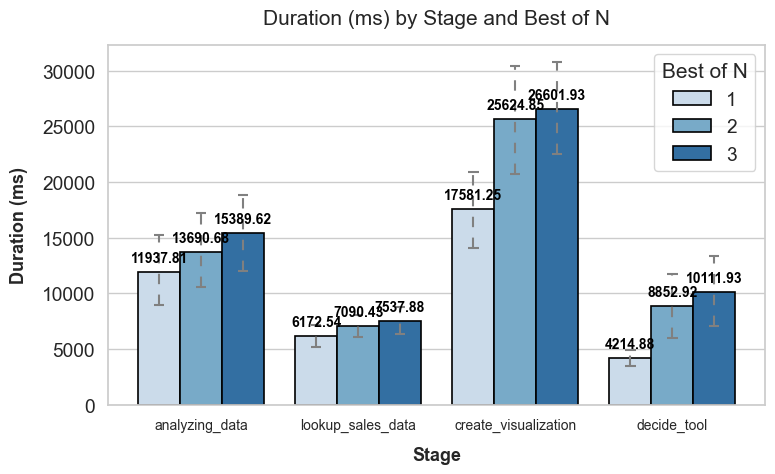

In [78]:
plot_pretty_bar(
    x='stage',
    y='duration_ms',
    hue='best_of_n',
    data=carbon,
    title="Duration (ms) by Stage and Best of N",
    y_name="Duration (ms)",
    x_name="Stage",
    out_path=out_dir / "stage_vs_duration_ms_best_of_n.png",
    legend_title="Best of N",
    x_tick_fontsize=10  # Example: reduce x-axis font size if you wish
)

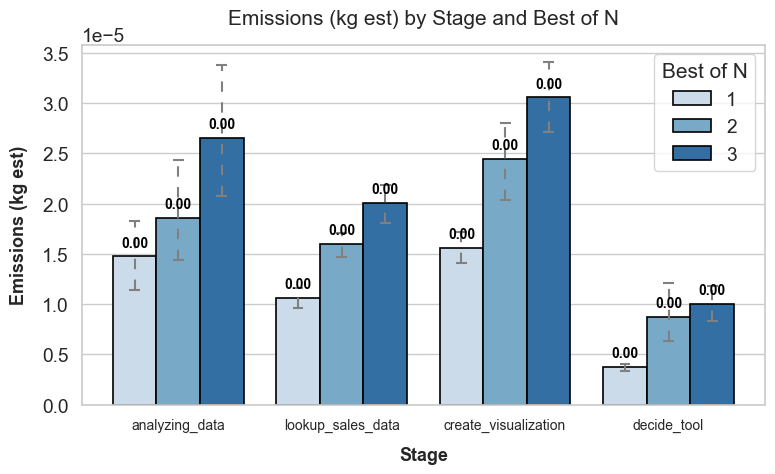

In [79]:
plot_pretty_bar(
    x='stage',
    y='emissions_kg_est',
    hue='best_of_n',
    data=carbon,
    title="Emissions (kg est) by Stage and Best of N",
    y_name="Emissions (kg est)",
    x_name="Stage",
    out_path=out_dir / "stage_vs_emissions_kg_est_best_of_n.png",
    legend_title="Best of N",
    x_tick_fontsize=10  # Example: reduce x-axis font size if you wish
)

In [80]:
scores = pd.read_csv('../exp5_bestof_sweep/scores_runs.csv')
scores.head(5)

,experiment,test_dir,test_case,rep,two_stage_cot,best_of_n,t0,tmax,prompt,csv_score,text_score,bleu,spice,best_score,best_idx,best_result_path
0,rep1_tsfalse_bon1_t0_tmax0p15,test_1,1,1,False,1,0.0,0.15,What is the total sales in october 2022 ?,1.0,0.715778,0.631555,0.80,1.715778,0.0,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
1,rep1_tsfalse_bon1_t0_tmax0p15,test_2,2,1,False,1,0.0,0.15,How many units we sold in september 2022 ?,0.0,0.363511,0.227023,0.50,0.363511,0.0,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
2,rep1_tsfalse_bon1_t0_tmax0p15,test_3,3,1,False,1,0.0,0.15,Find product categories that decreased sales d...,0.0,0.000011,0.000023,0.00,0.000011,0.0,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
3,rep1_tsfalse_bon1_t0_tmax0p15,test_4,4,1,False,1,0.0,0.15,How much was the variational change between in...,0.0,0.263344,0.276687,0.25,0.263344,0.0,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...
4,rep1_tsfalse_bon1_t0_tmax0p15,test_5,5,1,False,1,0.0,0.15,Which store has the most sales in october 2022 ?,0.5,0.706988,0.663976,0.75,1.206988,0.0,C:\Users\Recup\Documents\Polimi\PACS\DataAgent...


In [81]:
scores.columns 


Index(['experiment', 'test_dir', 'test_case', 'rep', 'two_stage_cot',
       'best_of_n', 't0', 'tmax', 'prompt', 'csv_score', 'text_score', 'bleu',
       'spice', 'best_score', 'best_idx', 'best_result_path'],
      dtype='object')

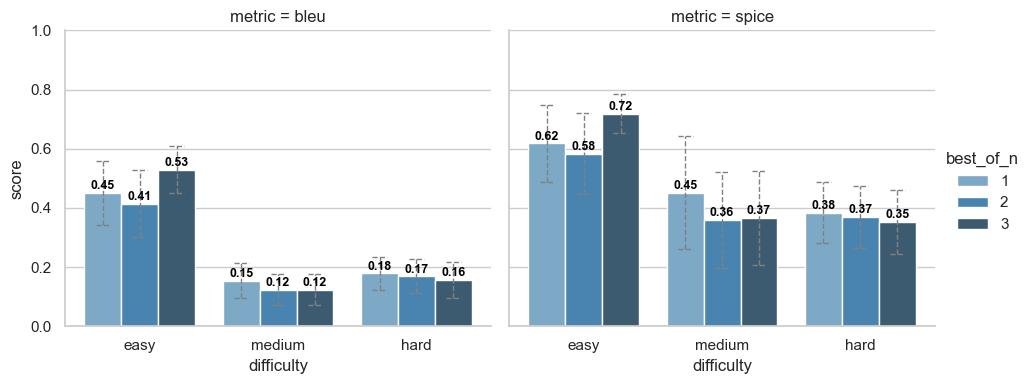

<Figure size 640x480 with 0 Axes>

In [82]:
import json, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

sns.set_theme(style="whitegrid")

scores = pd.read_csv('../exp5_bestof_sweep/scores_runs.csv')
ds = pd.DataFrame(json.load(open('../evaluation/miguel.json', 'r', encoding='utf-8')))[['prompt','difficulty']]
scores = scores.merge(ds, on='prompt', how='left')

# optional: focus on one config
# scores = scores[(scores['two_stage_cot'] == False)]

long = scores.melt(
    id_vars=['difficulty', 'best_of_n', 'two_stage_cot'],
    value_vars=['bleu', 'spice'],
    var_name='metric',
    value_name='score'
)

order = ['easy', 'medium', 'hard']

# Compute 95% confidence interval for each group
def mean_ci(series):
    n = series.count()
    if n < 2:
        return (np.nan, np.nan)
    m = series.mean()
    sem = stats.sem(series, nan_policy="omit")
    h = sem * stats.t.ppf((1 + 0.95) / 2, n - 1)
    return (m, h)

bar_data = (
    long
    .groupby(['difficulty', 'best_of_n', 'metric'], as_index=False)
    .agg(score_mean=('score', 'mean'), score_ci=('score', lambda x: mean_ci(x)[1]))
)

# Define the 'bleus' palette for up to 9 hues (as an example)
bleus_palette = sns.color_palette("Blues_d", n_colors=bar_data['best_of_n'].nunique())

g = sns.catplot(
    data=bar_data, kind='bar',
    x='difficulty', y='score_mean',
    hue='best_of_n',
    col='metric',
    order=order,
    height=4, aspect=1.2,
    legend=True,
    palette=bleus_palette  # Use bleus palette
)
g.set(ylim=(0, 1))
g.set_axis_labels("difficulty", "score")
g._legend.set_title("best_of_n")

# Add error bars: plot confidence intervals as dashed grey lines and a horizontal cap
axes = g.axes.flatten() if hasattr(g, 'axes') else [g.ax]

# For each facet, determine correct bar order for error bars
for i, ax in enumerate(axes):
    metric = bar_data['metric'].unique()[i]
    # Get unique best_of_n values actually present for this facet in shown order
    best_of_n_levels = sorted(bar_data[bar_data['metric'] == metric]['best_of_n'].unique())
    bar_count_per_group = len(order)
    total_bars = len(best_of_n_levels) * bar_count_per_group
    for bar_idx, bar in enumerate(ax.patches):
        # We iterate over (best_of_n, difficulty) for this facet
        group_idx = bar_idx // bar_count_per_group
        difficulty_idx = bar_idx % bar_count_per_group
        if group_idx >= len(best_of_n_levels):
            # More bars than actual legend/hue entries: skip to avoid IndexError
            continue
        difficulty = order[difficulty_idx]
        best_of_n = best_of_n_levels[group_idx]
        bar_row = bar_data[
            (bar_data['difficulty'] == difficulty) &
            (bar_data['metric'] == metric) &
            (bar_data['best_of_n'] == best_of_n)
        ]
        if not bar_row.empty:
            mean = bar_row['score_mean'].values[0]
            ci = bar_row['score_ci'].values[0]
            x = bar.get_x() + bar.get_width() / 2
            # Vertical dashed confidence interval line
            ax.plot([x, x], [mean - ci, mean + ci], color='grey', linestyle='--', linewidth=1)
            # Horizontal line (cap) at the top of the CI
            cap_width = bar.get_width() * 0.4
            ax.plot([x - cap_width / 2, x + cap_width / 2], [mean + ci, mean + ci], color='grey', linestyle='--', linewidth=1)
            # Horizontal line (cap) at the bottom of the CI
            ax.plot([x - cap_width / 2, x + cap_width / 2], [mean - ci, mean - ci], color='grey', linestyle='--', linewidth=1)
            # Add value label on the bar (score value)
            ax.text(
                x,                                # position x (center of bar)
                mean + 0.0025,                 # position y (just above top CI cap)
                f"{mean:.2f}", 
                ha='center', va='bottom', 
                fontsize=9, color='black', 
                fontweight='bold', rotation=0
            )

plt.show()

plt.savefig(out_dir / "bleu_spice_difficulty_best_of_n.png", dpi=300, bbox_inches="tight")